In [1]:
import re
import os
import mne
import math
import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mne.viz import plot_compare_evokeds
from mne.time_frequency import tfr_morlet
from mne.channels import find_ch_adjacency
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.stats import spatio_temporal_cluster_test, combine_adjacency
from sklearn.preprocessing import StandardScaler

import matplotlib.colors as mc

# Global variables
tab10 = list(mc.TABLEAU_COLORS.values())

event_map = {'Comment/101':101, 
             'Comment/109':109,
             'Comment/30':30,
             'Comment/40':40,
             'Comment/50':50,
             'Comment/51':51,
             'Comment/52':52,
             'Comment/60':60,
             'Comment/70':70,
             'Comment/80':80,
             'New Segment/':99999}

montage = mne.channels.read_custom_montage('./BC-MR3-64.bvef')

In [2]:
# Get active and sham groups from main csv
df = pd.read_csv('../joint/msc_collated_data_20230709.csv')
df = df[["participant_number", "session_type"]].drop_duplicates()

def remove_doubles(x):
    if(x.nunique()==2):
        return 'sham group'
    elif(x.nunique()==1):
        return 'active group'

df["condition"] = df.groupby('participant_number')['session_type'].transform(remove_doubles)
df = df.drop(columns="session_type").drop_duplicates()
df['participant_number'] = df['participant_number'].replace(r'sub-', r'm_', regex=True)

active_ids = df[df.condition=='active group'].participant_number.to_list()
sham_ids = df[df.condition=='sham group'].participant_number.to_list()
# active_ids, sham_ids

In [3]:
# Get list of filenames for each group:
cleaned_dir = './ica_notebooks/cleaned'

active_eeg_files = []
sham_eeg_files = []

for root, dirs, files in os.walk(cleaned_dir):
    for file in files:
        # Actives
        if file.endswith('.vhdr') and any(id in file for id in active_ids):
            active_eeg_files.append(os.path.join(root, file))
        # Sham 
        elif file.endswith('.vhdr') and any(id in file for id in sham_ids):
            sham_eeg_files.append(os.path.join(root, file))

active2bs = []
active2as = []
active1as = []
active1bs = []
sham2bs = []
sham2as = []
sham1as = []
sham1bs = []

# Just look at Posner 2b
for x in active_eeg_files:
    if 'pos2b' in x:
        active2bs.append(x)
    if 'pos1a' in x:
        active1as.append(x)
    if 'pos1b' in x:
        active1bs.append(x)
    if 'pos2a' in x:
        active2as.append(x)
for x in sham_eeg_files:
    if 'pos2b' in x:
        sham2bs.append(x)
    if 'pos1a' in x:
        sham1as.append(x)
    if 'pos1b' in x:
        sham1bs.append(x)
    if 'pos2a' in x:
        sham2as.append(x)

In [4]:
# All Posners tasks over all groups and sessions
all_pos = active2bs+active1as+active2as+active1bs+sham2as+sham2bs+sham1as+sham2bs

# Posners by condition
actives = active2as + active2bs + active1as + active1bs
shams = sham1as + sham1bs + sham2as +sham2bs

# Session only Posner tasks
all2s = active2bs+sham2bs+active2as+sham2as
all1s = active1as+active1bs+sham1as+sham1bs

# First or second only Posner
allbs = active2bs + active1bs + sham2bs + sham1bs
allas = active2as + active1as + sham2as + sham1as

In [5]:
def gather_epochs(file_names, event_ids=event_map):
    epochs_list = []
    for file in file_names:
        # Load raw
        raw = mne.io.read_raw(file, preload=True)
        print('dropping channel');raw.drop_channels('ECG')
        # Filter ?
        filt_raw = raw.copy().filter(l_freq=3, h_freq=40)
        # Events
        events, event_id = mne.events_from_annotations(filt_raw, event_map) # get events
        # Re-reference
        avg_ref = raw.copy().set_eeg_reference(ref_channels="average")
        # Epoch rejection rule
        reject_criteria=dict(eeg=500e6)
        # Get epochs
        epochs = mne.Epochs(raw=avg_ref, 
                            events=events, 
                            event_id=event_ids, 
                            reject=reject_criteria,
                            detrend=1, 
                            tmin=-0.5, 
                            tmax=2, 
                            # baseline=(-0.5, 0),
                            baseline=(0, None),
                            preload=True,
                            # picks=picks,
                            event_repeated='drop')

        epochs.set_montage(montage)
        epochs_list.append([epochs, file])
        del raw
    return epochs_list

In [6]:
# Import indivual alpha frequencies
df_iaf = pd.read_csv('./participant_IAF_frequencies.csv')
# Create a new DataFrame for iaf_2 values with session = 2
df_iaf_2 = df_iaf[['IAF_2', 'participant_id']].rename(columns={'IAF_2': 'IAF', 'participant_id': 'Participant'})
df_iaf_2['Session'] = 2

# Create a new DataFrame for iaf_1 values with session = 1
df_iaf_1 = df_iaf[['IAF_1', 'participant_id']].rename(columns={'IAF_1': 'IAF', 'participant_id': 'Participant'})
df_iaf_1['Session'] = 1
df_iaf = pd.concat([df_iaf_2, df_iaf_1], ignore_index=True)
df_iaf.head()

,IAF,Participant,Session
0,10.50,0,2
1,9.25,1,2
2,9.75,2,2
3,10.00,3,2
4,9.50,4,2


In [70]:
# Import baseline alpha data
baseline_powers = pd.read_csv('./baseline_powers.csv')
base_ec_powers = baseline_powers[baseline_powers['baseline type']=='baseline_ec']
base_ec_powers['participant'] = base_ec_powers['participant'].astype(int)
base_ec_powers['session'] = base_ec_powers['session'].astype(int)
base_ec_powers = base_ec_powers.drop(columns=['code', 'baseline', 'baseline type', 'time'])
base_ec_powers.rename(columns={'power': 'baseline_power', 'participant':'Participant', 'session':'Session'}, inplace=True)
base_ec_powers

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/1506380376.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_ec_powers['participant'] = base_ec_powers['participant'].astype(int)
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/1506380376.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_ec_powers['session'] = base_ec_powers['session'].astype(int)


,Participant,Session,ROI,baseline_power
4,0,1,"left central, occipital parietal",0.030866
5,0,1,"right central, occipital parietal",0.025412
6,0,1,left hemisphere,0.033111
7,0,1,right hemisphere,0.028484
12,0,2,"left central, occipital parietal",0.037767
...,...,...,...,...
327,20,1,right hemisphere,0.393435
332,20,2,"left central, occipital parietal",0.025782
333,20,2,"right central, occipital parietal",0.040676
334,20,2,left hemisphere,0.030095


In [7]:
# Gather up all the epochs for the relevant tasks and groups
all_pos_epochs = gather_epochs(all_pos)

Extracting parameters from ./ica_notebooks/cleaned/m_09_02/m_09_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 516619  =      0.000 ...   516.619 secs...
dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
308 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 308 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_19_02/m_19_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 686119  =      0.000 ...   686.119 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
3 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_02/m_07_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 678635  =      0.000 ...   678.635 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_02/m_03_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 696262  =      0.000 ...   696.262 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_16_02/m_16_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 700376  =      0.000 ...   700.376 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_02/m_15_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 687590  =      0.000 ...   687.590 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
409 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 409 events and 2501 original time points ...
3 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_02/m_20_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 507628  =      0.000 ...   507.628 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
308 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 308 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_02/m_14_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667933  =      0.000 ...   667.933 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_02/m_00_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 679689  =      0.000 ...   679.689 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_02/m_10_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668899  =      0.000 ...   668.899 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
409 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 409 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_11_01/m_11_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 675030  =      0.000 ...   675.030 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_01/m_15_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 703100  =      0.000 ...   703.100 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_01/m_14_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 687981  =      0.000 ...   687.981 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
409 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 409 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_01/m_20_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 498570  =      0.000 ...   498.570 secs...
dropping channel


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
307 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 307 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


3 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_01/m_10_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 665561  =      0.000 ...   665.561 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_01/m_00_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 685731  =      0.000 ...   685.731 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
409 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 409 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_19_01/m_19_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 605579  =      0.000 ...   605.579 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
306 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 306 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_09_01/m_09_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 699340  =      0.000 ...   699.340 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_01/m_07_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 686560  =      0.000 ...   686.560 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_01/m_03_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 667374  =      0.000 ...   667.374 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
409 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 409 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_16_01/m_16_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 676029  =      0.000 ...   676.029 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_09_02/m_09_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 516738  =      0.000 ...   516.738 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
307 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 307 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_02/m_07_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 703313  =      0.000 ...   703.313 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_02/m_03_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 667497  =      0.000 ...   667.497 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_11_02/m_11_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675340  =      0.000 ...   675.340 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_02/m_15_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 663436  =      0.000 ...   663.436 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
3 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_02/m_20_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 500248  =      0.000 ...   500.248 secs...
dropping channel

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
307 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 307 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_02/m_14_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 516705  =      0.000 ...   516.705 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
306 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 306 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_02/m_00_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675588  =      0.000 ...   675.588 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_02/m_10_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 667992  =      0.000 ...   667.992 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_11_01/m_11_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 685241  =      0.000 ...   685.241 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_01/m_15_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 665711  =      0.000 ...   665.711 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_01/m_14_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 686370  =      0.000 ...   686.370 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
409 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 409 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_01/m_20_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 498009  =      0.000 ...   498.009 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
307 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 307 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_01/m_10_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 667363  =      0.000 ...   667.363 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_01/m_00_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 680309  =      0.000 ...   680.309 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_19_01/m_19_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 736370  =      0.000 ...   736.370 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_09_01/m_09_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 535139  =      0.000 ...   535.139 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
308 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 308 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_01/m_07_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 669191  =      0.000 ...   669.191 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
409 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 409 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_01/m_03_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 673432  =      0.000 ...   673.432 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
409 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 409 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_16_01/m_16_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 667352  =      0.000 ...   667.352 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
3 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_02/m_08_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 728771  =      0.000 ...   728.771 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_02/m_18_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 668340  =      0.000 ...   668.340 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
409 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 409 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


3 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_02/m_17_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675771  =      0.000 ...   675.771 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
413 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 413 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_02/m_13_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675770  =      0.000 ...   675.770 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.9s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_02/m_02_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 700777  =      0.000 ...   700.777 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_02/m_12_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 674207  =      0.000 ...   674.207 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_06_02/m_06_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 690202  =      0.000 ...   690.202 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_02/m_01_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 687606  =      0.000 ...   687.606 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_02/m_05_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 681642  =      0.000 ...   681.642 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_02/m_04_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 679230  =      0.000 ...   679.230 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
3 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_02/m_08_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 508821  =      0.000 ...   508.821 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
308 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 308 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_02/m_18_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 660150  =      0.000 ...   660.150 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
3 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_02/m_17_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 699563  =      0.000 ...   699.563 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_02/m_13_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668631  =      0.000 ...   668.631 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_02/m_02_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667422  =      0.000 ...   667.422 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_02/m_12_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 675910  =      0.000 ...   675.910 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
413 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 413 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_02/m_01_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 690070  =      0.000 ...   690.070 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
409 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 409 events and 2501 original time points ...
3 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_02/m_05_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 706851  =      0.000 ...   706.851 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.9s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_02/m_04_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 683430  =      0.000 ...   683.430 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_01/m_01_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 691051  =      0.000 ...   691.051 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_01/m_05_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 689190  =      0.000 ...   689.190 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_01/m_04_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 670980  =      0.000 ...   670.980 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_01/m_18_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 663110  =      0.000 ...   663.110 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
3 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_01/m_08_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 699450  =      0.000 ...   699.450 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_01/m_17_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 671811  =      0.000 ...   671.811 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']


[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    0.7s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
413 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 413 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_01/m_13_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 665210  =      0.000 ...   665.210 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_01/m_12_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 686230  =      0.000 ...   686.230 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_01/m_02_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 680040  =      0.000 ...   680.040 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_06_01/m_06_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 689061  =      0.000 ...   689.061 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
409 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 409 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_02/m_08_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 508821  =      0.000 ...   508.821 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
308 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 308 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_02/m_18_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 660150  =      0.000 ...   660.150 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
3 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_02/m_17_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 699563  =      0.000 ...   699.563 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_02/m_13_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668631  =      0.000 ...   668.631 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.9s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_02/m_02_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667422  =      0.000 ...   667.422 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
411 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 411 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_02/m_12_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 675910  =      0.000 ...   675.910 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
413 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 413 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_02/m_01_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 690070  =      0.000 ...   690.070 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
409 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 409 events and 2501 original time points ...
3 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_02/m_05_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 706851  =      0.000 ...   706.851 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_02/m_04_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 683430  =      0.000 ...   683.430 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
410 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 410 events and 2501 original time points ...
2 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_936/3128575474.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


In [8]:
# Create power table and helpers
def get_psd_power_norm(ep, roi, freq_range):
    evoked = ep.average()
    spectrum = evoked.compute_psd('welch', fmin=3, fmax=30, tmin=0, tmax=1, picks=roi)
    psds, freqs = spectrum.get_data(return_freqs=True)
    psds_band = psds[:, (freqs >= freq_range[0]) & (freqs < freq_range[1])].mean(axis=-1)
    psds /= np.sum(psds,axis=-1, keepdims=True) # Normalise
    psds_band_norm = psds[:, (freqs >= freq_range[0]) & (freqs < freq_range[1])].mean(axis=-1)
    return psds_band.mean(), psds_band_norm.mean()

def create_power_table(epoch_set, iaf_data):
    """Create a table of powers for each eeg file in the list supplied.
    """
    output = {
        'Participant':[],
        'ROI':[],
        'Cue':[],
        'Session':[],
        'Power':[],
        'Normalised Power':[]
    }

    regions = {
        'left central, occipital parietal' : ["P7", "P5", "P3", "P1", "PO7", "PO3", "O1", "CP5", "CP3", "CP1"],
        'right central, occipital parietal' : ["P2", "P4", "P6", "P8", "PO8", "PO4", "O2", "CP6", "CP4", "CP2"],
        'left hemisphere':["P7", "P5", "P3", "P1", "PO7", "PO3", "O1"],
        'right hemisphere':["P2", "P4", "P6", "P8", "PO8", "PO4", "O2"]
    }

    cue_key = [
        ['left','Comment/60'],
        ['right','Comment/70'],
    ]

    for i in range(len(cue_key)):
        # cue_epochs = gather_epochs(, cue_key[i][1])
        cue_id = cue_key[i][1]
        for key, value in regions.items():
            for sub_epochs in epoch_set:
                epochs = sub_epochs[0][cue_id]
                sub_id=sub_epochs[1].strip('/ica_notebooks/cleaned/')
                sub_id=re.search(r"/([^/]*)$", sub_id).group(1)
                sub_id=re.findall(r'm_([^_]*)', sub_id)[0]
                session=re.search(r".*pos(\d)\D.*", sub_epochs[1]).group(1)

                ### USE individualised alpha range ###
                # Get iaf and alpha range for subject
                iaf = iaf_data[(iaf_data['Participant']==int(sub_id)) & (iaf_data['Session']==int(session))].IAF.iloc[0]
                print('iaf', iaf)
                a_min = math.floor(iaf - 1)
                a_max = math.ceil(iaf + 1) 
                freq_range = (a_min, a_max)
                ###

                epochs=sub_epochs[0]
                # mean_alpha_o, normed_mean_alpha_o = get_psd_power_normed(epochs, value, freq_range)
                mean_alpha, normed_mean_alpha = get_psd_power_norm(epochs, value, freq_range)

                output['Participant'].append(sub_id)
                output['ROI'].append(key)
                output['Power'].append(mean_alpha)
                output['Normalised Power'].append(normed_mean_alpha)
                output['Cue'].append(cue_key[i][0])
                output['Session'].append(session)
    return pd.DataFrame(output)

In [75]:
# Custom function to determine the 'hemisphere' value
def determine_hemisphere(roi):
    if 'left' in roi:
        return 'left'
    elif 'right' in roi:
        return 'right'
    else:
        return 'unknown'

# Compare alpha power from different regions

In [95]:
iaf_data = df_iaf
cue_key = [
        ['left','Comment/60'],
        ['right','Comment/70'],
]
output = {
        'Participant':[],
        'ROI':[],
        'Cue':[],
        'Session':[],
        'Power':[],
        'Normalised Power':[]
    }
regions = {
        'left central, occipital parietal' : ["P7", "P5", "P3", "P1", "PO7", "PO3", "O1", "CP5", "CP3", "CP1"],
        'right central, occipital parietal' : ["P2", "P4", "P6", "P8", "PO8", "PO4", "O2", "CP6", "CP4", "CP2"],
        'left hemisphere':["P7", "P5", "P3", "P1", "PO7", "PO3", "O1"],
        'right hemisphere':["P2", "P4", "P6", "P8", "PO8", "PO4", "O2"]
}
for k in range(len(cue_key)): 
    cue_id = cue_key[k][1]
    for key, value in regions.items():
        for e in all_pos_epochs:
            sub_id=e[1].strip('/ica_notebooks/cleaned/')
            sub_id=re.search(r"/([^/]*)$", sub_id).group(1)
            sub_id=re.findall(r'm_([^_]*)', sub_id)[0]
            session=re.search(r".*pos(\d)\D.*", e[1]).group(1)
            ## USE individualised alpha range ###
            # Get iaf and alpha range for subject
            iaf = iaf_data[(iaf_data['Participant']==int(sub_id)) & (iaf_data['Session']==int(session))].IAF.iloc[0]
            print('iaf', iaf)
            a_min = math.floor(iaf - 1)
            a_max = math.ceil(iaf + 1) 
            freq_range = (a_min, a_max)
            ###
            a, na = get_psd_power_norm(e[0][cue_id], value, freq_range)
            output['Participant'].append(sub_id)
            output['ROI'].append(key)
            output['Power'].append(a)
            output['Normalised Power'].append(na)
            output['Cue'].append(cue_key[k][0])
            output['Session'].append(session)

powers_all = pd.DataFrame(output)

iaf 9.75
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.5
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 9.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.5
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.5
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 11.0
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 8.75
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Effective window size : 1.001 (s)
iaf 10.5
NOTE: pi

In [96]:
powers_all['Participant'] = powers_all['Participant'].astype(int)
powers_all['Session'] = powers_all['Session'].astype(int)
powers_baselines = pd.merge(powers_all, base_ec_powers, on=['Participant', 'ROI', 'Session'])
powers_baselines['Baselined Power'] = powers_baselines['Normalised Power'] - powers_baselines['baseline_power']
powers_baselines['hemisphere'] = powers_baselines['ROI'].apply(determine_hemisphere)
powers_baselines

,Participant,ROI,Cue,Session,Power,Normalised Power,baseline_power,Baselined Power,hemisphere
0,9,"left central, occipital parietal",left,2,4.682160e-14,0.088690,0.235656,-0.146966,left
1,9,"left central, occipital parietal",left,2,1.178195e-14,0.032161,0.235656,-0.203494,left
2,9,"left central, occipital parietal",right,2,9.579263e-14,0.153612,0.235656,-0.082043,left
3,9,"left central, occipital parietal",right,2,5.265054e-14,0.132950,0.235656,-0.102706,left
4,19,"left central, occipital parietal",left,2,5.027058e-13,0.217079,0.032240,0.184839,left
...,...,...,...,...,...,...,...,...,...
627,12,right hemisphere,right,1,6.398936e-15,0.008827,0.132196,-0.123369,right
628,2,right hemisphere,left,1,5.753695e-14,0.076309,0.056173,0.020136,right
629,2,right hemisphere,right,1,2.466035e-13,0.225690,0.056173,0.169517,right
630,6,right hemisphere,left,1,1.902213e-14,0.060375,0.031859,0.028517,right


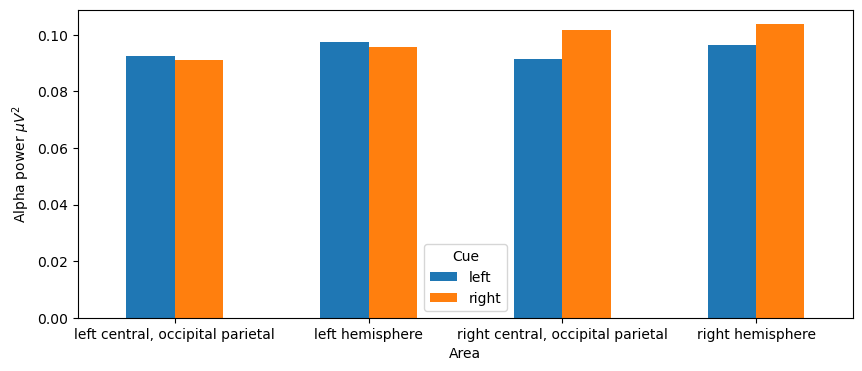

In [97]:
powers_grouped = powers_all.groupby(['ROI', 'Cue'])['Normalised Power'].mean().reset_index()

powers_pivot = powers_grouped.pivot(index='ROI', columns='Cue', values='Normalised Power')
powers_pivot.plot(kind='bar', figsize=(10, 4), color=tab10)

plt.ylabel(r'Alpha power $\mu V^{2}$')
plt.xlabel('Area')
plt.xticks(rotation=0)
# plt.ylim(-1.6e-17, 1.5e-17)
plt.show()

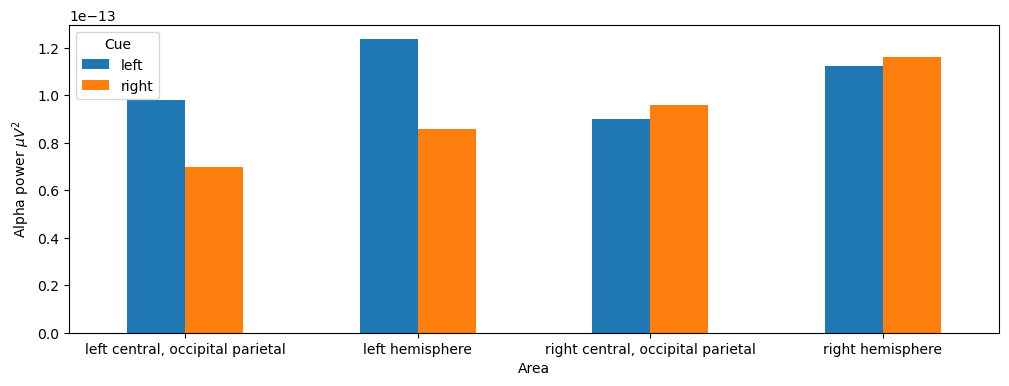

In [88]:
powers_grouped = powers_all.groupby(['ROI', 'Cue'])['Power'].mean().reset_index()

powers_pivot = powers_grouped.pivot(index='ROI', columns='Cue', values='Power')
powers_pivot.plot(kind='bar', figsize=(12, 4), color=tab10)

plt.ylabel(r'Alpha power $\mu V^{2}$')
plt.xlabel('Area')
plt.xticks(rotation=0)
# plt.ylim(-1.6e-17, 1.5e-17)
plt.show()

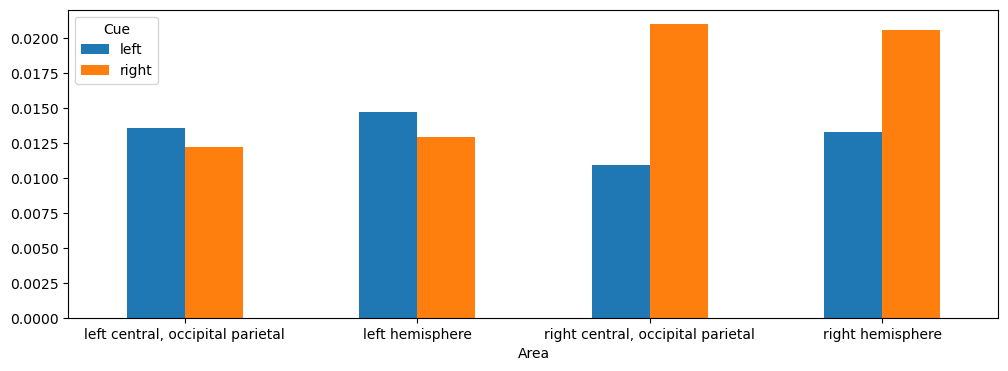

In [91]:
powers_grouped = powers_baselines.groupby(['ROI', 'Cue'])['Baselined Power'].mean().reset_index()

# powers_grouped = powers_grouped[~powers_grouped['ROI'].isin(['left hemisphere', 'right hemisphere'])]

powers_pivot = powers_grouped.pivot(index='ROI', columns='Cue', values='Baselined Power')
powers_pivot.plot(kind='bar', figsize=(12, 4), color=tab10)

# plt.ylabel(r'Alpha power $\mu V^{2}$')
plt.xlabel('Area')
plt.xticks(rotation=0)
# plt.ylim(1e-12, 3.6e-12)
plt.show()